In [40]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import BaselineOnly

import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

from surprise.model_selection import train_test_split

from surprise import KNNWithMeans  #Memory based, Collaborative Based Filtering
from surprise import SVD  #Model Based, Matrix Factorization

from surprise.model_selection import GridSearchCV

from surprise import accuracy

In [2]:
# Loads the builtin Movielens-100k data
data = Dataset.load_builtin("ml-100k")

raw_ratings = data.raw_ratings

# A = 75% of the data, B = 25% of the data
threshold = int(.75 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

In [3]:
#Memory based, Collaborative-based filtering
sim_options = {
    "name": ["cosine"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}

gs_knn = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=5)
gs_knn.fit(data)



Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [4]:
print(gs_knn.best_score["rmse"])
print(gs_knn.best_params["rmse"])


0.9554638887485669
{'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}}


Centered-KNN algorithm works best if you go with item-based approach and use cosine similarity as the similarity metric with minimum support 3.
Cosine considers common and absolute ratings.
However some people like to rate high, even they do not like the item very much. However, some people tend to rate low, even they like the items very much. The traditional cosine similarity does not account for the preference of the user’s rating.)

In [5]:
# We can now use the algorithm that yields the best rmse:
algo_knn = gs_knn.best_estimator['rmse']

# Train the algorithm on the trainset, and predict ratings for the testset

# retrain on the whole set A
trainset = data.build_full_trainset()

algo_knn.fit(trainset)

'''
# Compute biased accuracy on A
predictions = algo_knn.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
# Compute RMSE
accuracy.rmse(predictions)
# Compute MSE
accuracy.mse(predictions)
# Compute MAE
accuracy.mae(predictions)

'''
# Compute unbiased accuracy on B
testset1 = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions = algo_knn.test(testset1)
print('Unbiased accuracy on B,', end=' ')
# Compute RMSE
accuracy.rmse(predictions)
# Compute MSE
accuracy.mse(predictions)
# Compute MAE
accuracy.mae(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Unbiased accuracy on B, RMSE: 0.9402
MSE: 0.8840
MAE:  0.7419


0.7418984725084533

In [6]:
#Model based, Matrix Factorization, SVD

param_grid = {
    "n_epochs": [5, 10, 15],
    "lr_all": [0.002, 0.005, 0.008],
    "reg_all": [0.2, 0.4, 0.6]
}
gs_svd = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5)

gs_svd.fit(data) #data is A raw ratings

print(gs_svd.best_score["rmse"])
print(gs_svd.best_params["rmse"])


0.9526154678402164
{'n_epochs': 15, 'lr_all': 0.008, 'reg_all': 0.2}


In [7]:
# We can now use the algorithm that yields the best rmse:
algo_svd = gs_svd.best_estimator['rmse']

# Train the algorithm on the trainset, and predict ratings for the testset
# retrain on the whole set A
trainset = data.build_full_trainset()
algo_svd.fit(trainset)  # retrain on the whole set A


# Compute biased accuracy on A
predictions_A = algo_svd.test(trainset.build_testset())
print('Biased accuracy on A,', end='   ')
# Compute RMSE
accuracy.rmse(predictions_A)
# Compute MSE
accuracy.mse(predictions_A)
# Compute MAE
accuracy.mae(predictions_A)


# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions_B = algo_svd.test(testset)
print('Unbiased accuracy on B,', end=' ')
# Compute RMSE
accuracy.rmse(predictions_B)
# Compute MSE
accuracy.mse(predictions_B)
# Compute MAE
accuracy.mae(predictions_B)

Biased accuracy on A,   RMSE: 0.9123
MSE: 0.8324
MAE:  0.7265
Unbiased accuracy on B, RMSE: 0.9428
MSE: 0.8889
MAE:  0.7535


0.7535394673671477

Neural Network

In [38]:
#neural network

r_cols = ['user_id','movie_id','rating','unix_timestamp']
ratings = pd.read_csv('C:/LSY/Metis/syleo22_sgp20_ds4/Project4/Movie Recommender System/Grouplens/ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

m_cols = ['movie_id','title','release_date','video_release_date','imdb_url','unknown','Action','Adventure','Animation',
          'Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance',
          'Sci-Fi','Thriller','War','Western']
movies = pd.read_csv('C:/LSY/Metis/syleo22_sgp20_ds4/Project4/Movie Recommender System/Grouplens/ml-100k/u.item', sep='|', names=m_cols,encoding='latin-1')

# create one merged DataFrame
lens = pd.merge(movies, ratings)

In [9]:
lens

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children,...,Thriller,War,Western,user_id,rating,unix_timestamp,age,gender,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,308,5,887736696,60,M,retired,95076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,748,"Saint, The (1997)",14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Saint%2C%20Th...,0,1,0,0,0,...,1,0,0,729,4,893286638,19,M,student,56567
99996,751,Tomorrow Never Dies (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,0,0,...,1,0,0,729,3,893286338,19,M,student,56567
99997,879,"Peacemaker, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Peacemaker%2C...,0,1,0,0,0,...,1,1,0,729,3,893286299,19,M,student,56567
99998,894,Home Alone 3 (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,1,...,0,0,0,729,1,893286511,19,M,student,56567


In [39]:
lens = movie_ratings.drop(['release_date','video_release_date','imdb_url','unix_timestamp', 'unknown','Action','Adventure','Animation',
          'Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance',
          'Sci-Fi','Thriller','War','Western'], axis = 1)
lens

,movie_id,title,user_id,rating
0,1,Toy Story (1995),308,4
1,1,Toy Story (1995),287,5
2,1,Toy Story (1995),148,4
3,1,Toy Story (1995),280,4
4,1,Toy Story (1995),66,3
...,...,...,...,...
99995,1678,Mat' i syn (1997),863,1
99996,1679,B. Monkey (1998),863,3
99997,1680,Sliding Doors (1998),863,2
99998,1681,You So Crazy (1994),896,3


In [45]:
#list out all users, no repetition of users and place an index to each user.
user_ids = lens["user_id"].unique().tolist()

#index all the unique users
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
print(user2user_encoded)

userencoded2user = {i: x for i, x in enumerate(user_ids)}
print(userencoded2user)

{308: 0, 287: 1, 148: 2, 280: 3, 66: 4, 5: 5, 109: 6, 181: 7, 95: 8, 268: 9, 189: 10, 145: 11, 158: 12, 67: 13, 232: 14, 150: 15, 289: 16, 117: 17, 49: 18, 223: 19, 56: 20, 17: 21, 340: 22, 177: 23, 194: 24, 250: 25, 213: 26, 350: 27, 348: 28, 131: 29, 106: 30, 234: 31, 43: 32, 20: 33, 246: 34, 94: 35, 279: 36, 38: 37, 128: 38, 96: 39, 203: 40, 157: 41, 311: 42, 125: 43, 286: 44, 83: 45, 301: 46, 345: 47, 18: 48, 322: 49, 64: 50, 45: 51, 247: 52, 204: 53, 271: 54, 41: 55, 274: 56, 222: 57, 15: 58, 23: 59, 141: 60, 359: 61, 374: 62, 380: 63, 10: 64, 320: 65, 160: 66, 396: 67, 339: 68, 199: 69, 422: 70, 81: 71, 42: 72, 357: 73, 26: 74, 327: 75, 200: 76, 44: 77, 256: 78, 174: 79, 97: 80, 243: 81, 101: 82, 490: 83, 242: 84, 312: 85, 325: 86, 456: 87, 347: 88, 360: 89, 450: 90, 84: 91, 198: 92, 494: 93, 525: 94, 2: 95, 62: 96, 343: 97, 298: 98, 459: 99, 407: 100, 471: 101, 535: 102, 500: 103, 512: 104, 275: 105, 252: 106, 230: 107, 249: 108, 93: 109, 514: 110, 193: 111, 484: 112, 54: 113, 7

In [46]:
#list out all movies, no repetition of movies and place an index to each movies.
movie_ids = lens["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print(movie2movie_encoded)

movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
print(movie_encoded2movie)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 120, 122: 12

In [47]:
lens["userfind"] = lens["user_id"].map(user2user_encoded)
lens["moviefind"] = lens["movie_id"].map(movie2movie_encoded)

print (lens)

       movie_id                                      title  user_id  rating  \
0             1                           Toy Story (1995)      308     4.0   
1             1                           Toy Story (1995)      287     5.0   
2             1                           Toy Story (1995)      148     4.0   
3             1                           Toy Story (1995)      280     4.0   
4             1                           Toy Story (1995)       66     3.0   
...         ...                                        ...      ...     ...   
99995      1678                          Mat' i syn (1997)      863     1.0   
99996      1679                           B. Monkey (1998)      863     3.0   
99997      1680                       Sliding Doors (1998)      863     2.0   
99998      1681                        You So Crazy (1994)      896     3.0   
99999      1682  Scream of Stone (Schrei aus Stein) (1991)      916     3.0   

       userfind  moviefind  
0             0       

In [48]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)

lens["rating"] = lens["rating"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(lens["rating"])
max_rating = max(lens["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 943, Number of Movies: 1682, Min rating: 1.0, Max rating: 5.0


In [70]:
#Prepare training and validation data, set seed, normalise rating

#lens = lens.sample(frac=1, random_state=123)
x = lens[["userfind", "moviefind"]].values

# Normalize the targets between 0 and 1. Makes it easy to train.
y = lens["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 75% of the data and validating on 25%.
train_indices = int(0.75 * lens.shape[0])  #take 75% of the rows as training data

x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [59]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        
        
        
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0]) #all rows of column 0
        user_bias = self.user_bias(inputs[:, 0])  #all rows of column 0
        movie_vector = self.movie_embedding(inputs[:, 1]) #all rows of column 1
        movie_bias = self.movie_bias(inputs[:, 1])  #all rows of column 1
        
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)



In [60]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1172/1172 [==============================] - 1s 797us/step - loss: 0.6426 - val_loss: 0.6800
Epoch 2/5
1172/1172 [==============================] - 1s 677us/step - loss: 0.6165 - val_loss: 0.6739
Epoch 3/5
1172/1172 [==============================] - 1s 670us/step - loss: 0.6086 - val_loss: 0.6703
Epoch 4/5
1172/1172 [==============================] - 1s 663us/step - loss: 0.6050 - val_loss: 0.6684
Epoch 5/5
1172/1172 [==============================] - 1s 672us/step - loss: 0.6046 - val_loss: 0.6672


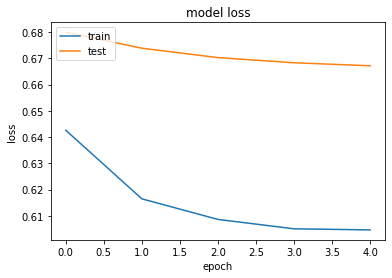

In [61]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [89]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    keras.optimizers.Adam(lr=0.001), loss="mean_squared_error",
    metrics=["mean_absolute_error", "mean_squared_error"])

In [90]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1172/1172 [==============================] - 1s 948us/step - loss: 0.0760 - mean_absolute_error: 0.2273 - mean_squared_error: 0.0759 - val_loss: 0.0815 - val_mean_absolute_error: 0.2292 - val_mean_squared_error: 0.0814
Epoch 2/5
1172/1172 [==============================] - 1s 692us/step - loss: 0.0635 - mean_absolute_error: 0.2043 - mean_squared_error: 0.0633 - val_loss: 0.0784 - val_mean_absolute_error: 0.2274 - val_mean_squared_error: 0.0782
Epoch 3/5
1172/1172 [==============================] - 1s 705us/step - loss: 0.0598 - mean_absolute_error: 0.1959 - mean_squared_error: 0.0596 - val_loss: 0.0767 - val_mean_absolute_error: 0.2261 - val_mean_squared_error: 0.0765
Epoch 4/5
1172/1172 [==============================] - 1s 694us/step - loss: 0.0584 - mean_absolute_error: 0.1925 - mean_squared_error: 0.0582 - val_loss: 0.0757 - val_mean_absolute_error: 0.2250 - val_mean_squared_error: 0.0755
Epoch 5/5
1172/1172 [==============================] - 1s 693us/step - loss: 0.0576 

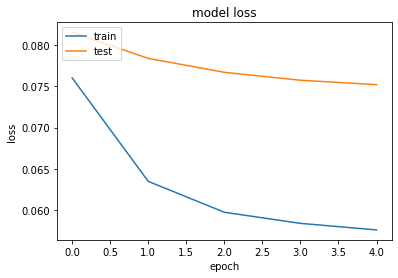

In [91]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [105]:
# Let us get a user and see the top recommendations.
user_selected = lens.user_id.sample(1).iloc[0]  #the first row of df lens3.

movies_watched_by_user = lens[lens.user_id == user_selected]
print(movies_watched_by_user)

       movie_id                                              title  user_id  \
374           1                                   Toy Story (1995)      838   
1284          7                              Twelve Monkeys (1995)      838   
1561          8                                        Babe (1995)      838   
1860          9                            Dead Man Walking (1995)      838   
2427         12                         Usual Suspects, The (1995)      838   
...         ...                                                ...      ...   
90713       945                                     Charade (1963)      838   
92201       993                                    Hercules (1997)      838   
92360      1005  Double vie de Véronique, La (Double Life of Ve...      838   
93863      1039                                      Hamlet (1996)      838   
95798      1115                               Twelfth Night (1996)      838   

       rating  userfind  moviefind  
374       5.0 

In [106]:
movies_not_watched = lens[~lens["movie_id"].isin(movies_watched_by_user.movie_id.values)
]["movie_id"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_selected)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)  #user_movie_array consists of selected_user in userfind and moviefind

rate = model.predict(user_movie_array)
ratings = model.predict(user_movie_array).flatten()

#For any iterable in python [-10:] denotes the indexing of last 10 items of that iterable.
#[::-1] denotes same list in reverse order
#returns top 10 max ratings' indices
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

In [107]:
print(user_movie_array)
print(rate)


[[ 374    1]
 [ 374    2]
 [ 374    3]
 ...
 [ 374 1679]
 [ 374 1680]
 [ 374 1681]]
[[0.52442974]
 [0.5005499 ]
 [0.5897111 ]
 ...
 [0.5948881 ]
 [0.6134972 ]
 [0.5920295 ]]


In [108]:
print (top_ratings_indices)


[521  76 140  51 156 407 145 154  69 136]


In [113]:
print("Showing recommendations for user: {}".format(user_selected))
print("@~~~~~@" * 6)
print("Movies with high ratings from user")
print("@~~~~~@" * 6)

top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(10).movie_id.values)
#print(top_movies_user)

lens_rows = lens[lens["movie_id"].isin(top_movies_user)]
lens_rows = lens_rows.drop_duplicates(subset = ["title"])
#print(lens3_rows)

for row in lens_rows.itertuples(): #The itertuples() function is used to iterate over DataFrame rows as namedtuples.
    print(row.title)

print("@~~~~~@" * 6)
print("Top 10 movie recommendations")
print("@~~~~~@" * 6)

recommended_movies = lens[lens["movie_id"].isin(recommended_movie_ids)]
recommended_movies = recommended_movies.drop_duplicates(subset = ["title"])

for row in recommended_movies.itertuples():
    print(row.title)

Showing recommendations for user: 838
@~~~~~@@~~~~~@@~~~~~@@~~~~~@@~~~~~@@~~~~~@
Movies with high ratings from user
@~~~~~@@~~~~~@@~~~~~@@~~~~~@@~~~~~@@~~~~~@
Toy Story (1995)
Godfather, The (1972)
Sound of Music, The (1965)
Empire Strikes Back, The (1980)
Princess Bride, The (1987)
Clockwork Orange, A (1971)
Evita (1996)
Titanic (1997)
Schindler's List (1993)
Mary Poppins (1964)
@~~~~~@@~~~~~@@~~~~~@@~~~~~@@~~~~~@@~~~~~@
Top 10 movie recommendations
@~~~~~@@~~~~~@@~~~~~@@~~~~~@@~~~~~@@~~~~~@
Shawshank Redemption, The (1994)
Blade Runner (1982)
Silence of the Lambs, The (1991)
Cinema Paradiso (1988)
12 Angry Men (1957)
Psycho (1960)
Graduate, The (1967)
Bridge on the River Kwai, The (1957)
Casablanca (1942)
Rear Window (1954)
